# Predicting the Stock Market through LSTM Regression

## Import and Data Loading

In [ ]:
import os
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Mount to the data
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ML_Datasets')

# Confirm we're in the correct drive
print(os.listdir())

sp = pd.read_csv('SP500_sentiment.csv').dropna(subset=['Close/Last'])

Mounted at /content/drive
['mnist_test.csv', 'mnist_train.csv', 'checkpoints', 'SP500.csv', 'batch1.h5', 'batch1.keras', 'SP500_sentiment.csv']


## Hyperparameters

In [ ]:
window_size = 50 # @param {type:"number"}
shift = 1 # @param {type:"number"}
label_width = 1 # @param {type:"number"}
train_perc = 0.75 # @param {type:"number"}
valid_perc = 0.15 # @param {type:"number"}
test_perc = 1 - (train_perc + valid_perc)

batch_size = 30 # @param {type:"number"}
epochs = 100 # @param {type:"number"}
units = 55  # @param {type:"number"}

## Data Preprocessing

### Data Extraction & Splitting

In [ ]:
# Extract closing prices from the SP500 dataset (MAKING SURE TO REVERSE IT)
prices = np.array(sp['Close/Last'])

# Split our data
n = len(prices)
train_df = prices[:int(n * train_perc)]
valid_df = prices[int(n*train_perc):int(n * (train_perc + valid_perc))]
test_df = prices[int(n*(train_perc + valid_perc)):]

### Data Window Normalisation

In [ ]:
# Represents a normalised winow, keeping track of the scaler used to normalise
# and denormalise a window, and the inputs and labels of the window
class NormalisedWindow():
  def __init__(self, winputs, wlabels, wscaler):
    self.winputs = winputs
    self.wlabels = wlabels
    self.wscaler = wscaler

# Generates windows and handles the normalisation and denormalisation of windows
class WindowManager():

  def __init__(self, input_width=window_size, label_width=label_width, shift=shift,
               train_df=train_df, valid_df=valid_df, test_df=test_df):
    # Store the raw data
    self.train_df = train_df
    self.valid_df = valid_df
    self.test_df = test_df

    # Work out the window parameters
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + label_width

    # Create the windows
    self.train_windows = self.create_windows(self.train_df)
    self.valid_windows = self.create_windows(self.valid_df)
    self.test_windows = self.create_windows(self.test_df)

    # Normalise the windows
    self.normal_train_windows = self.normalise_window(self.train_windows)
    self.normal_valid_windows = self.normalise_window(self.valid_windows)
    self.normal_test_windows = self.normalise_window(self.test_windows)

    # Simple test for checking correct denormalisation
    self.d_test = self.denormalise_window(self.normal_train_windows)

  # Creates windows from our raw data
  def create_windows(self, raw_data):
    # Store created windows
    windows = []

    # Manually perform windowing, taking shift into account
    curr_shift = 0
    while curr_shift < len(raw_data) - self.total_window_size:
      # Get the window input data
      input_data = raw_data[curr_shift:curr_shift + self.input_width]
      # Get the window label data
      label_data = raw_data[curr_shift + self.input_width:curr_shift + self.total_window_size]

      # Save the created window
      windows.append((input_data, label_data))

      # Go to the next shift
      curr_shift += shift

    return windows

  # Normalises our windows
  def normalise_window(self, windows):
    # Join the window's inputs and labels
    joined_windows = [np.append(x, y) for (x, y) in windows]

    # Reshape and perform minmaxscaler on each window individually
    normalised_windows = []
    for i, window in enumerate(joined_windows):
      scaler = MinMaxScaler(feature_range=(0, 1))
      transformed_values = scaler.fit_transform(window.reshape(-1, 1)).reshape(-1)
      normalised_windows.append(NormalisedWindow(transformed_values[:self.input_width], transformed_values[self.input_width:], scaler))

    return normalised_windows

  # Denormalise our windows

  # This joins results with the input values they were predicted from, and
  # denormalises them together.
  def denormalise_results(self, inputs, results, scalers):

    # Join the inputs and results
    joined_values = []
    for i, values in enumerate(inputs):
      joined_values.append(np.append(values, results[i]))

    # Denormalise the joined values
    output = []
    for i, values in enumerate(joined_values):
      scaler = scalers[i]
      denorm_values = scaler.inverse_transform(values.reshape(-1, 1)).reshape(-1)
      output.append(denorm_values[-1])

    return output

  # Method that simply denormalises a normalised window to check that the values
  # are correct
  def denormalise_window(self, normalised_windows):

    output = []
    for window in normalised_windows:
      values = np.append(window.winputs, window.wlabels)
      tmp = window.wscaler.inverse_transform(values.reshape(-1, 1))
      tmp = tmp.reshape(-1)
      output.append(tmp)

    return output

# Create a Window Manager instance
window_manager = WindowManager()

## Model Architecture

### Defining the Model Architecture

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

# Tensorflow has no built-in RMSE loss function - have to define our own
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError(name="MSE"), tf.keras.metrics.RootMeanSquaredError(name="RMSE"), tf.keras.metrics.R2Score(name="R2")])

## Training the Model

In [ ]:
# Extract our training data
train_inputs = np.array([n_window.winputs for n_window in window_manager.normal_train_windows])
train_labels = np.array([n_window.wlabels for n_window in window_manager.normal_train_windows])

# Extract our validation data
valid_inputs = np.array([n_window.winputs for n_window in window_manager.normal_valid_windows])
valid_labels = np.array([n_window.wlabels for n_window in window_manager.normal_valid_windows])

# Extract our testing data
test_inputs = np.array([n_window.winputs for n_window in window_manager.normal_test_windows])
test_labels = np.array([n_window.wlabels for n_window in window_manager.normal_test_windows])

history = lstm_model.fit(train_inputs, train_labels,
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_data=(valid_inputs, valid_labels))

Epoch 1/100
25/25 [==============================] - 6s 42ms/step - loss: 0.1096 - MSE: 0.1096 - RMSE: 0.3311 - R2: -0.3092 - val_loss: 0.0423 - val_MSE: 0.0423 - val_RMSE: 0.2056 - val_R2: 0.3218
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0512 - MSE: 0.0512 - RMSE: 0.2262 - R2: 0.3893 - val_loss: 0.0354 - val_MSE: 0.0354 - val_RMSE: 0.1883 - val_R2: 0.4315
Epoch 3/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0444 - MSE: 0.0444 - RMSE: 0.2106 - R2: 0.4703 - val_loss: 0.0356 - val_MSE: 0.0356 - val_RMSE: 0.1888 - val_R2: 0.4282
Epoch 4/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0409 - MSE: 0.0409 - RMSE: 0.2023 - R2: 0.5113 - val_loss: 0.0326 - val_MSE: 0.0326 - val_RMSE: 0.1805 - val_R2: 0.4773
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0379 - MSE: 0.0379 - RMSE: 0.1947 - R2: 0.5475 - val_loss: 0.0249 - val_MSE: 0.0249 - val_RMSE: 0.1578 - val_R2: 0.6007
Epoch 6/100
25/25 [====

## Qualitative Analysis

### Extracted Prices

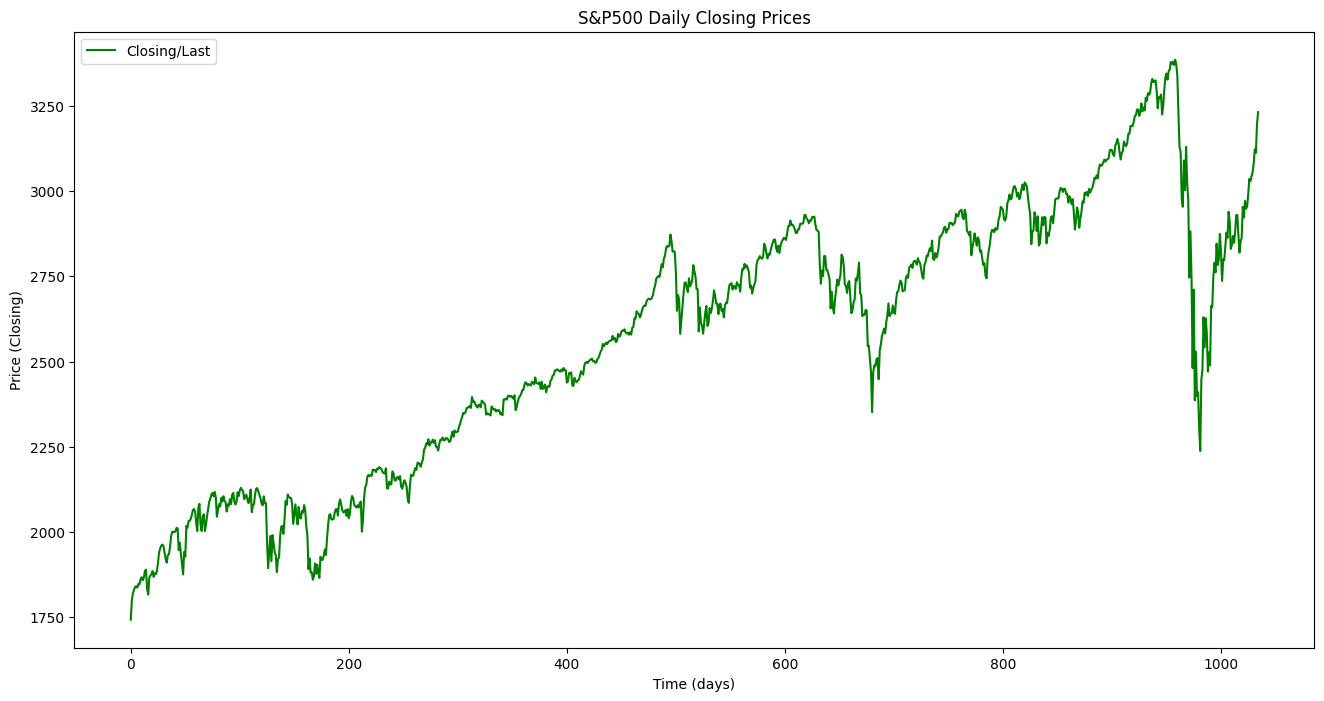

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(prices, color='green', label='Closing/Last')
plt.title('S&P500 Daily Closing Prices')
plt.xlabel('Time (days)')
plt.ylabel('Price (Closing)')
plt.legend()
plt.show()

### Distribution of Pre-Normalised Data

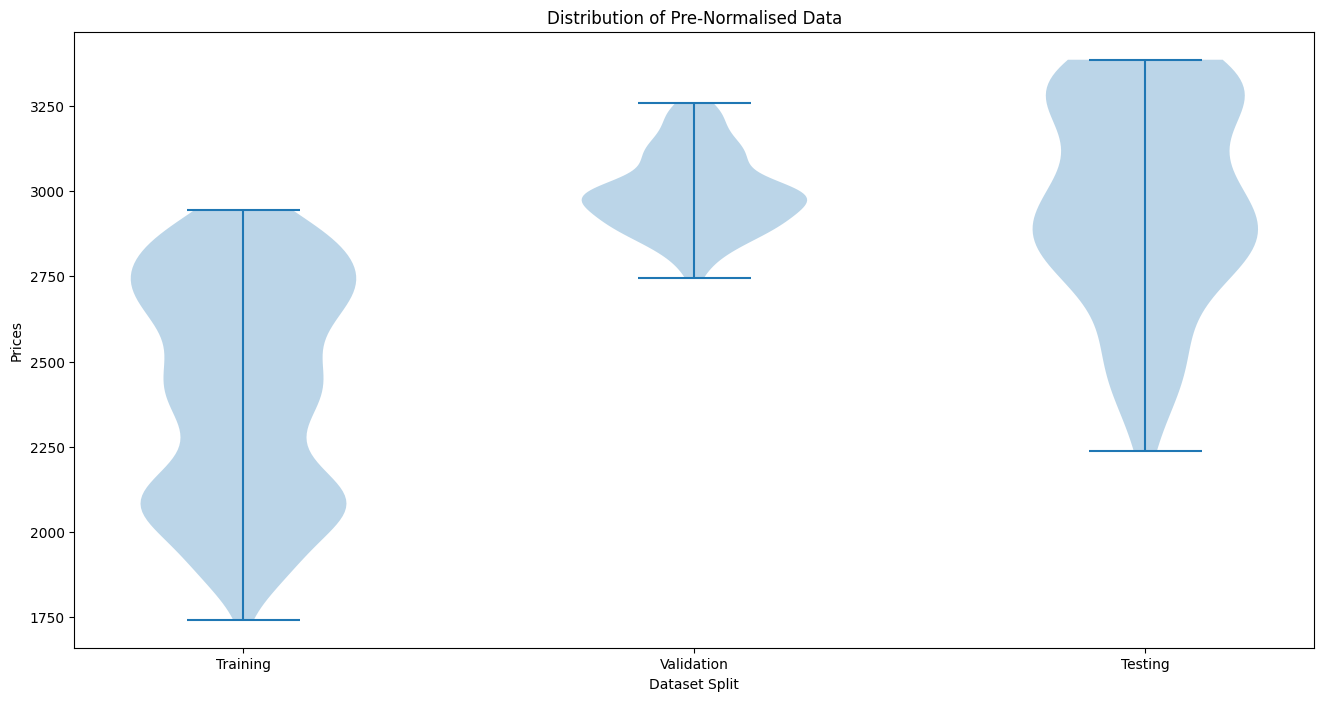

In [ ]:
plt.figure(figsize=(16,8))
plt.violinplot([train_df, valid_df, test_df])
plt.xticks([1, 2, 3], ['Training', 'Validation', 'Testing'])
plt.xlabel('Dataset Split')
plt.ylabel('Prices')
plt.title('Distribution of Pre-Normalised Data')
plt.show()

### Distribution of Normalised Data

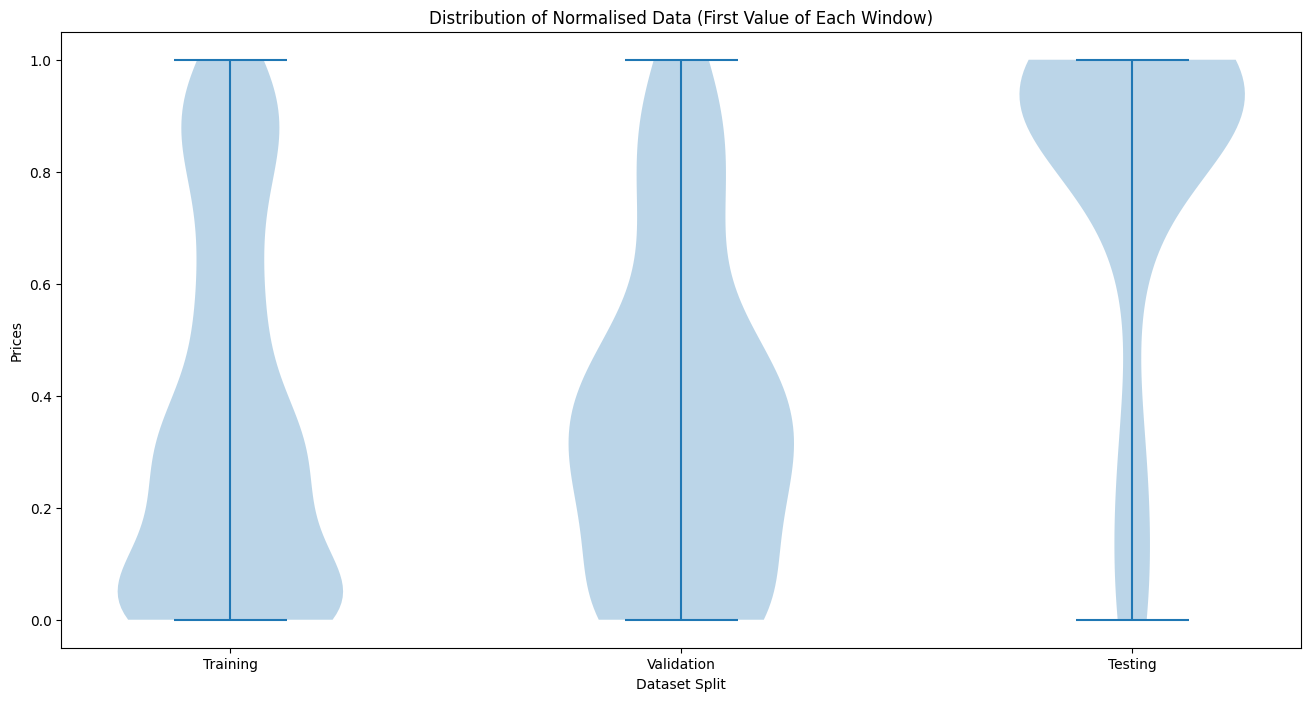

In [ ]:
tr = [values.winputs[0] for values in window_manager.normal_train_windows]
va = [values.winputs[0] for values in window_manager.normal_valid_windows]
te = [values.winputs[0] for values in window_manager.normal_test_windows]

# Combine input and label data
plt.figure(figsize=(16,8))
plt.violinplot([tr, va, te])
plt.xticks([1, 2, 3], ['Training', 'Validation', 'Testing'])
plt.xlabel('Dataset Split')
plt.ylabel('Prices')
plt.title('Distribution of Normalised Data (First Value of Each Window)')
plt.show()

### Training Metrics

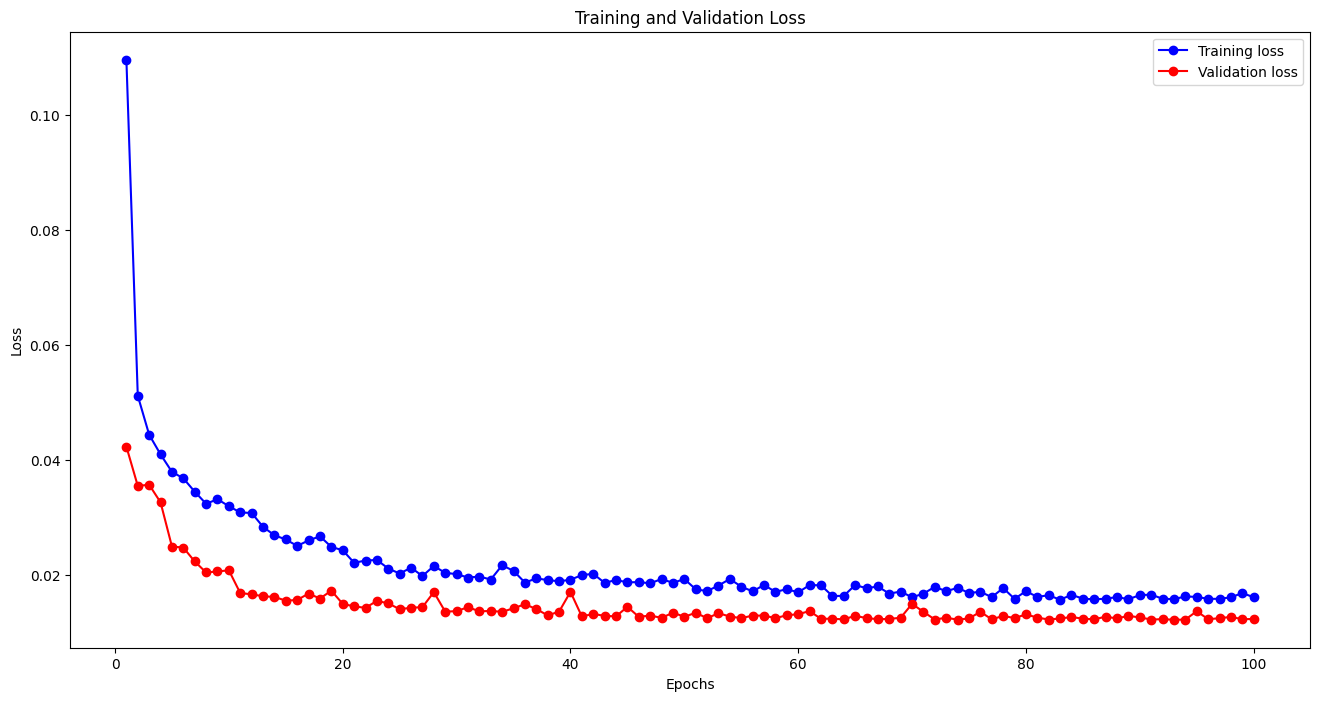

In [ ]:
# Extracting the data (LOSS)
epochs_his = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Creating subplots for loss and accuracy
plt.figure(figsize=(16, 8))

# Plotting training and validation loss
plt.plot(epochs_his, train_loss, 'bo-', label='Training loss')
plt.plot(epochs_his, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()

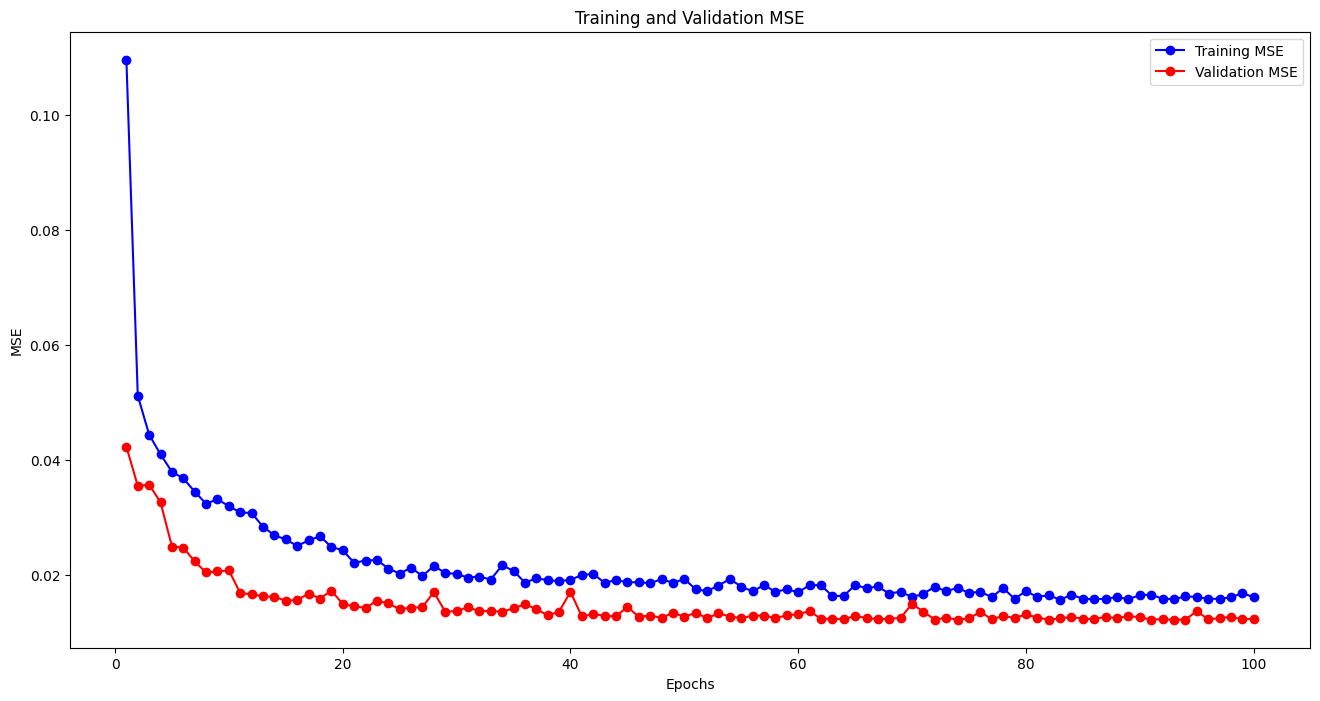

In [ ]:
# Extracting the data (MSE)
train_MSE = history.history['MSE']
val_MSE = history.history['val_MSE']

# Creating subplots for loss and accuracy
plt.figure(figsize=(16, 8))

# Plotting training and validation loss
plt.plot(epochs_his, train_MSE, 'bo-', label='Training MSE')
plt.plot(epochs_his, val_MSE, 'ro-', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Display the plots
plt.show()

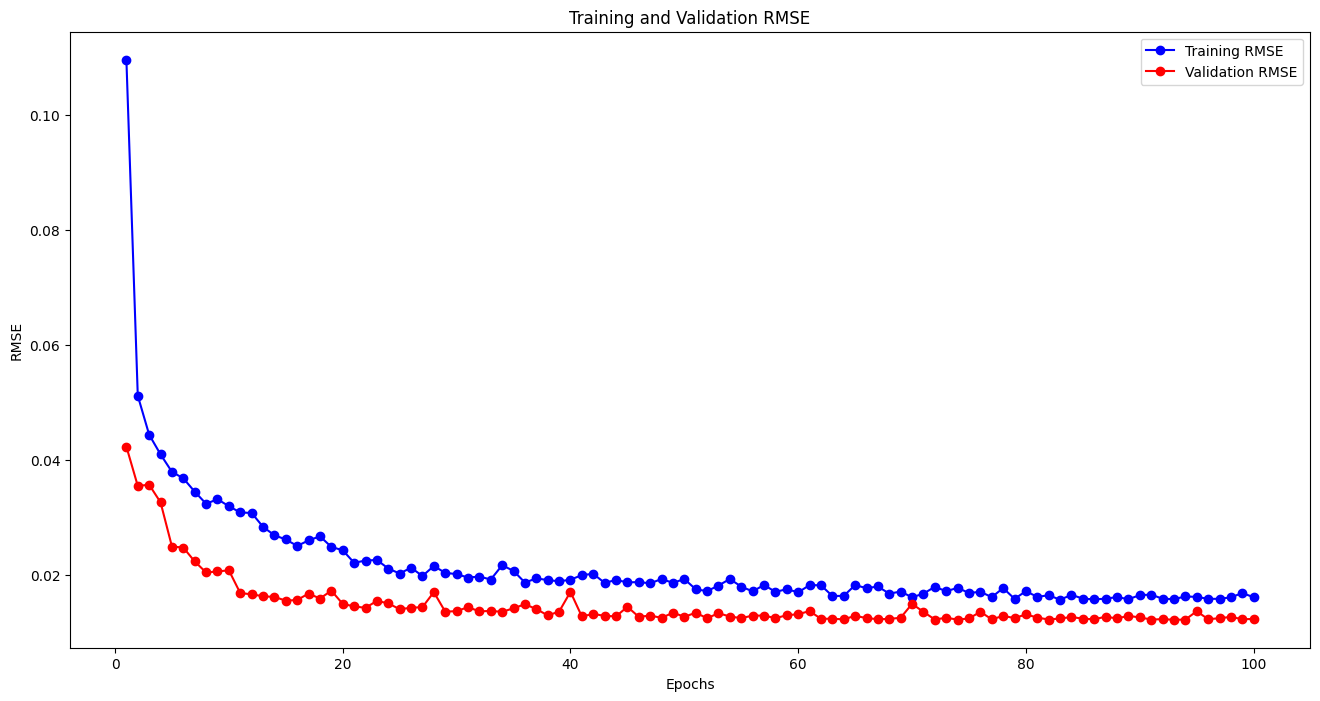

In [ ]:
# Extracting the data (RMSE)
train_RMSE = history.history['RMSE']
val_RMSE = history.history['val_RMSE']

# Creating subplots for loss and accuracy
plt.figure(figsize=(16, 8))

# Plotting training and validation loss
plt.plot(epochs_his, train_MSE, 'bo-', label='Training RMSE')
plt.plot(epochs_his, val_MSE, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Display the plots
plt.show()

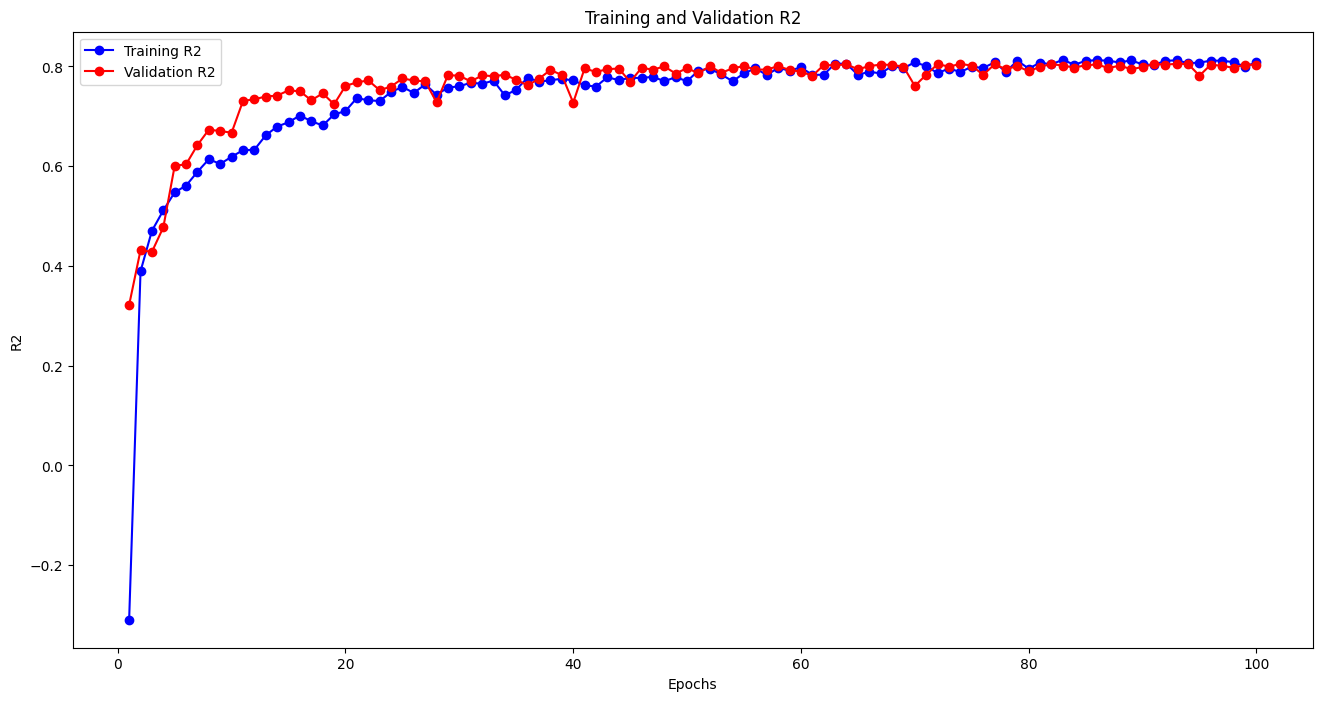

In [ ]:
# Extracting the data (R2)
train_R2 = history.history['R2']
val_R2 = history.history['val_R2']

# Creating subplots for loss and accuracy
plt.figure(figsize=(16, 8))

# Plotting training and validation loss
plt.plot(epochs_his, train_R2, 'bo-', label='Training R2')
plt.plot(epochs_his, val_R2, 'ro-', label='Validation R2')
plt.title('Training and Validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()

# Display the plots
plt.show()

### Test Data Predictions

2/2 [==============================] - 1s 6ms/step
[0.12216713 0.05629835 0.13702057 0.2017812  0.32002518 0.31676883
 0.36076385 0.34971994 0.27520615 0.2789371  0.25916454 0.35791463
 0.39569035 0.466382   0.514075   0.50784385 0.56228554 0.5307126
 0.53555095 0.5865815  0.56145465 0.49977934 0.5287148  0.53215426
 0.5613704  0.59669924 0.5935645  0.6473879  0.6416099  0.59875435
 0.65813184 0.7402433  0.7227499  0.7555637  0.8037219  0.80702275
 0.7500492  0.700077   0.81191343 0.86986846 1.0094674  0.93834925
 1.0129874  0.9688707  0.964197   0.9560795  1.0042508  0.98381674
 0.99294585 0.9765931  0.96313983 1.0065625  0.9044066 ]


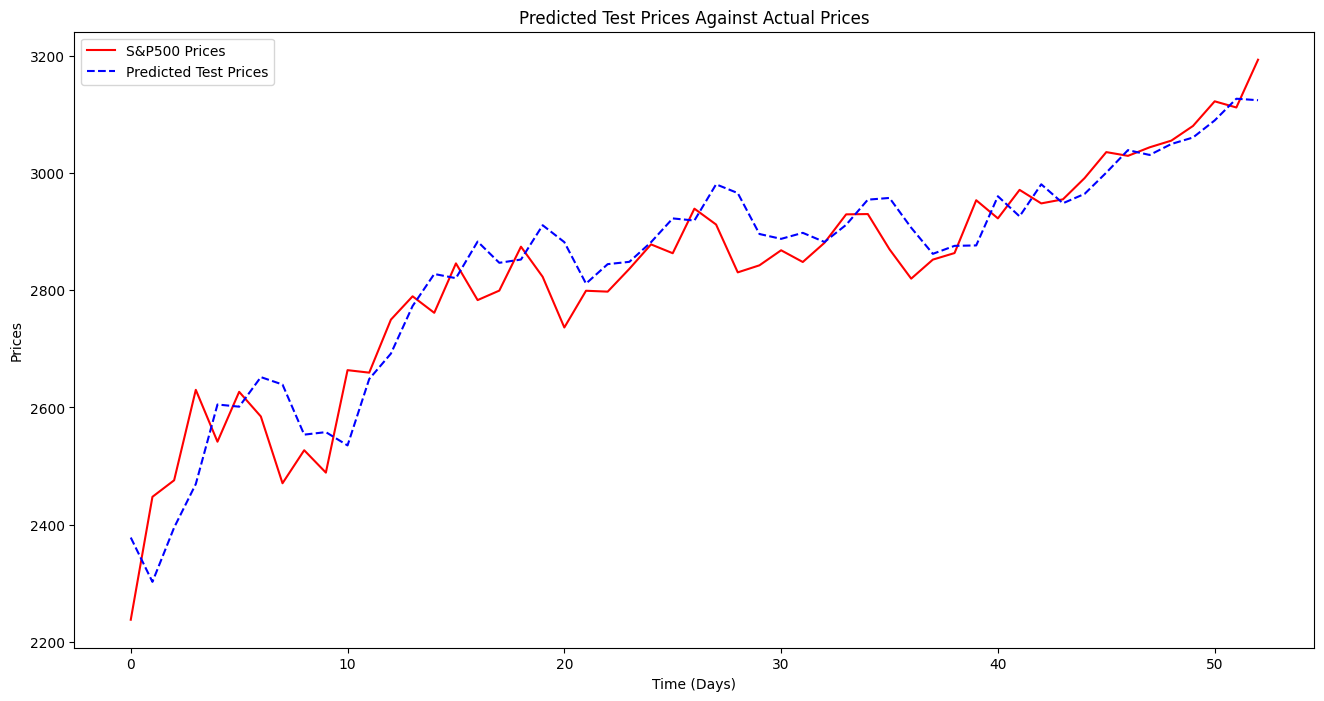

In [ ]:
# Perform Inferences using our test data
predicted_values = lstm_model.predict(test_inputs).reshape(-1)
# Extract the scalers from our test data to denormalise our results
scalers = [window.wscaler for window in window_manager.normal_test_windows]
# Denormalise the results
denorm_results = window_manager.denormalise_results(test_inputs, predicted_values, scalers)

print(predicted_values)

# Extract the actual test data pre-normalisation to plot predicted values against
test_values = [y for (x, y) in window_manager.test_windows]

plt.figure(figsize=(16,8))
plt.plot(test_values, color='red', label='S&P500 Prices')
plt.plot(denorm_results, color='blue', linestyle='--', label='Predicted Test Prices')
# plt.plot(denorm_results[1:], color='blue', linestyle='--', label='Predicted Test Prices')
# plt.plot(test_values[:-1], color='red', label='S&P500 Prices')
plt.title('Predicted Test Prices Against Actual Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Prices')
plt.legend()
plt.show()

## Misc

In [ ]:
# Test to see if we're capturing all data in our split
print(f"DATA SPLIT:\n\tTraining #: {len(train_df)}\n\tValidation #: {len(valid_df)}\n\tTesting #: {len(test_df)}\n\tTotal #: {len(train_df) + len(valid_df) + len(test_df)}\n\tOriginal #: {len(prices)}")

# print(window_manager.denormalise_window(window_manager.normal_train_windows))
# print(len(window_manager.denormalise_window(window_manager.normal_train_windows)[0]))

testing = np.array([
4868.55,
4864.60,
4850.43,
4839.81,
4780.94,
4739.21,
4765.98,
4783.83,
4780.24,
4783.45,
4756.50,
4763.54,
4697.24,
4688.68,
4704.81,
4742.83,
4769.83,
4783.35,
4781.58,
4774.75,
4754.63,
4746.75,
4698.35,
4768.37,
4740.56,
4719.19,
4719.55,
4707.09,
4643.70,
4622.44,
4604.37,
4585.59,
4549.34,
4567.18,
4569.78,
4594.63,
4567.80,
4550.58,
4554.89,
4550.43,
4559.34,
4556.62,
4538.19,
4547.38,
4514.02,
4508.24,
4502.88,
4495.70,
4411.55,
4415.24,
4347.35,
4382.78,
4378.38,
4365.98,
4358.34,
4317.78,
4237.86,
4193.80,
4166.82,
4117.37,
4137.23,
4186.77,
4247.68,
4217.04,
4224.16,
4278.00,
4314.60,
4373.20,
4373.63,
4327.78,
4349.61,
4376.95,
4358.24,
4335.66,
4308.50,
4258.19,
4263.75,
4229.45,
4288.39,
4288.05,
4299.70,
4274.51,
4273.53,
4337.44,
4320.06,
4330.00,
4402.20,
4443.95,
4453.53,
4450.32,
4505.10,
4467.44,
4461.90,
4487.46,
4457.49,
4451.14,
4465.48,
4496.83,
4515.77,
4507.66,
])[::-1]

print(len(testing) )
t_scaler = MinMaxScaler(feature_range=(0, 1))
sca_ts = np.array([t_scaler.fit_transform(testing.reshape(-1, 1)).reshape(-1)])
sca_ts = np.array([sca_ts[0]])
print(len(sca_ts[0]))

print(sca_ts)

pre = lstm_model.predict(np.array(sca_ts))

print(pre)

ans = t_scaler.inverse_transform(pre)

print(ans)


# Perform Inferences using our test data
#predicted_values = lstm_model.predict(test_inputs).reshape(-1)


DATA SPLIT:
	Training #: 776
	Validation #: 155
	Testing #: 104
	Total #: 1035
	Original #: 1035
100
100
[[0.51956921 0.53036556 0.50515189 0.46341756 0.44432759 0.45278096
  0.49267819 0.45865172 0.46602678 0.51616124 0.44323598 0.44750925
  0.43475598 0.37917676 0.28306132 0.2698288  0.29296573 0.20788626
  0.20919087 0.24272478 0.22721585 0.22766847 0.14920525 0.19486674
  0.18746505 0.25443968 0.29059613 0.3206555  0.34556298 0.30916691
  0.28010597 0.34114327 0.34057084 0.26256024 0.2138369  0.142163
  0.13268458 0.17347373 0.09238798 0.0264384  0.         0.06582976
  0.10174659 0.16040097 0.26679358 0.32078863 0.33095929 0.34746665
  0.3533241  0.30615831 0.39653612 0.39162385 0.50364759 0.51320589
  0.52034133 0.52803589 0.57244602 0.56021193 0.58474667 0.58836763
  0.5765063  0.58244362 0.57670598 0.59962992 0.63534705 0.60226577
  0.59880455 0.57505525 0.62331265 0.64831332 0.67236881 0.70067094
  0.78505818 0.80164541 0.80116617 0.82961474 0.86663649 0.77342315
  0.83785511 